## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

# Imports

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


In [3]:
import pandas.util.testing as tm

In [5]:
df = pd.read_csv('../data/pair_features1_300_60.CSV')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries
0,2015-01-02,CAG,21.161,NOC,126.094,28.241,149.160,27.868,144.540,5126379.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,CAG,20.931,NOC,123.433,28.023,146.470,27.564,142.450,5400213.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,CAG,20.724,NOC,124.114,27.743,146.000,27.167,141.580,5229051.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,CAG,21.214,NOC,128.040,27.977,148.830,27.432,144.880,3124092.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,CAG,21.675,NOC,131.010,28.560,153.140,28.054,149.810,4154019.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['pnls'] = df['pnls']*100.0

In [7]:
total_days = df.Date.nunique()
total_days

1257

In [8]:
print(df.shape)
df.isna().sum()

(1257000, 27)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
abs_spread_mean              299000
abs_spread_std               299000
abs_spread_mean_l28           27000
abs_spread_std_l28            27000
spread_normed                299000
abs_spread_normed_max        598000
abs_spread_normed_90th       598000
abs_spread_normed_75th       598000
abs_spread_normed_median     598000
abs_spread_normed_l7_avg     305000
abs_spread_normed_l14_avg    312000
cos_sim                      299000
corr_coef                    299000
pnls                         360000
num_entries                  360000
dtype: int64

In [9]:
df.Date.nunique()

1257

In [10]:
df.abs_spread_normed_max.dropna().describe()

count   659000.000
mean         3.137
std          0.610
min          1.280
25%          2.786
50%          3.052
75%          3.363
max          6.871
Name: abs_spread_normed_max, dtype: float64

In [11]:
# tmp_df = df[(df.Ticker_P1 == 'TDY') & (df.Ticker_P2 == 'PEP')]
# tmp_df.head()

In [12]:
# tmp_df.abs_spread_normed_max

In [13]:
df = df.sort_values('Date')

In [14]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


# Feature Engineering

In [15]:
# TODO:
# 1. Add group based features
# 2. Stock2Vec based features
# 3. Add Technical Indicators
# 4. target is a sum of 2 directions with magnitudes (how much it goes up/down per leg)
# 5. rolling features
# 6. probability of classification model
# 7. historical pnl and num_entries, drop leaky num_entries
# 8. differencing features.

In [16]:
# 3 dimensions from a product perspective: ticker1, ticker2, and pair
# 2 dimensions from a time perspective: short term vs long term
# 2 factors of PnL: Volatility, and Reversion to mean

# short term ticker 1 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term ticker 2 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term pair level volatility: rolling mean, sector rolling mean, rolling std, sector rolling std, 
#                                   differences of ticker level features

# long term ticker 1 volatility: beta,
# long term ticker 2 volatility: beta,
# long term pair level volatility: most recent PNL (which is from 120 days ago), average historical PNL
#                                  most recent number of entries, historical average vnumber of entries, 
#                                  diff of beta

# short term ticker 1 reversion to mean: technical indicators
# short term ticker 2 reversion to mean: technical indicators
# short term pair level reversion to mean: technical indicators

# long term ticker 1 reversion to mean: technical indicators
# long term ticker 2 reversion to mean: technical indicators
# long term pair level reversion to mean: technical indicators

## Technical Indicators

In [17]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [18]:
import yfinance as yf
spy_df=yf.download('SPY', start='1999-12-01', end='2023-12-31')
spy_df=spy_df.reset_index()
spy_df['Date'] = spy_df['Date'].dt.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed


In [19]:
#spy_df = pd.read_csv('../data/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
df = pd.merge(df,spy_df,on='Date',how='left')

# # Define a variable to calculate the return if we just buy SPY and sell in the next 30 days
# spy_30_return = []
# for i in range(spy_df.shape[0]):
#     if (i + 30) < spy_df.shape[0]:
#         spy_30_return.append(
#             100*(spy_df.loc[i+30]['SPY_Close'] - spy_df.loc[i]['SPY_Close'])/spy_df.loc[i]['SPY_Close']
#         )
#     else:
#         spy_30_return.append(
#             np.nan
#         )
# spy_df['SPY_return_next_30'] = spy_30_return

In [20]:
# del spy_df
# gc.collect()

### Beta

In [21]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta


In [22]:
## are we double countring here ??
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

478

In [23]:
# all_tickers = list(set(df['Ticker_P1'].unique()) | set(df['Ticker_P2'].unique()))
# len(all_tickers)

In [24]:
fe_obj = feature_engineering()


### Single Ticker Features

In [25]:
#df = df.drop(columns=['SPY_Close_x', 'SPY_Close_y'])
df.columns


Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_l28',
       'abs_spread_std_l28', 'spread_normed', 'abs_spread_normed_max',
       'abs_spread_normed_90th', 'abs_spread_normed_75th',
       'abs_spread_normed_median', 'abs_spread_normed_l7_avg',
       'abs_spread_normed_l14_avg', 'cos_sim', 'corr_coef', 'pnls',
       'num_entries', 'SPY_Close'],
      dtype='object')

In [26]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()

    single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
                                        args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)

    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)

  0%|          | 0/478 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [27]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

(600846, 21)

In [28]:
df = df.reset_index(drop=True)

In [29]:
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,SPY_Close
1256998,2019-12-30,NOC,325.704,PH,192.395,350.750,207.000,346.890,205.300,575500.000,...,2.100,1.557,1.084,0.081,0.084,0.994,0.547,NaN,NaN,301.500
1256999,2019-12-30,TEL,88.834,MAS,44.764,95.770,48.360,94.950,47.890,1006500.000,...,1.720,1.386,0.839,0.092,0.139,0.997,0.871,NaN,NaN,301.500


In [30]:
all_tickers_df.tail(2)

,Date,Ticker,Close,High,Low,Volume,SPY_Close,rolling_beta,rsi,kama,...,vpt,atr,bb_ma,adx,ema,macd,dlr,daily_returns,50 Days Average,200 Days Average
600844,2019-12-27,GM,35.471,36.710,36.430,5753500.000,303.171,1.057,53.648,35.099,...,12395624.200,1.494,34.959,15.499,35.328,0.154,0.219,0.002,35.259,35.631
600845,2019-12-30,GM,35.354,36.640,36.200,5353900.000,301.500,1.057,52.117,35.110,...,12378050.147,1.470,34.999,14.526,35.331,0.146,-0.329,-0.003,35.271,35.629


In [31]:
print(df.shape)
all_tickers_df_P1_suffix = all_tickers_df.copy()
all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
all_tickers_df_P2_suffix = all_tickers_df.copy()
all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P1']).drop_duplicates()
print(df.shape)
df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P2']).drop_duplicates()
print(df.shape)
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)


(1257000, 28)
(1257000, 48)
(1257000, 68)
(1257000, 67)


In [32]:
# del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
# gc.collect()

In [33]:
df = df.drop('Ticker',axis=1)

## Add group based features

### Merge Sector

In [34]:
sector_df = pd.read_csv('../data/1999-12-01-2023-12-31.csv')
sector_df = sector_df.drop_duplicates(subset=['Ticker','GICS Sector'])[['Ticker','GICS Sector']]
sector_df

,Ticker,GICS Sector
0,MMM,Industrials
6059,AOS,Industrials
12118,ABT,Health Care
18177,ABBV,Health Care
20945,ACN,Information Technology
...,...,...
2675145,YUM,Consumer Discretionary
2681204,ZBRA,Information Technology
2687263,ZBH,Health Care
2692907,ZION,Financials


In [35]:
industry_df = pd.read_csv('../data/1999-12-01-2023-12-31.csv')
industry_df = industry_df.drop_duplicates(subset=['Ticker','GICS Sub-Industry'])[['Ticker','GICS Sub-Industry']]
industry_df

,Ticker,GICS Sub-Industry
0,MMM,Industrial Conglomerates
6059,AOS,Building Products
12118,ABT,Health Care Equipment
18177,ABBV,Biotechnology
20945,ACN,IT Consulting & Other Services
...,...,...
2675145,YUM,Restaurants
2681204,ZBRA,Electronic Equipment & Instruments
2687263,ZBH,Health Care Equipment
2692907,ZION,Regional Banks


In [36]:
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)

In [37]:
# del sector_df
# del industry_df
# gc.collect()

### Prev Values

In [38]:
df = df.sort_values('Date')

In [39]:
df['PREV_num_entries'] = df.groupby(['Ticker_P1','Ticker_P2']).num_entries.shift(61)
df['PREV_pnls'] = df.groupby(['Ticker_P1','Ticker_P2']).pnls.shift(61)

# Trim head and tail days

In [40]:
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(61).index,axis=0)
print(df.shape)


(1257000, 72)
(956000, 72)
(895000, 72)


### Sector

In [41]:
all_sectors = df['Sector_P1'].unique().tolist()+df['Sector_P2'].unique().tolist()
len(all_sectors)

15

In [42]:
all_sectors_df_list = []
for s in tqdm(all_sectors):
    single_sector_df = (df[df['Sector_P1']==s] if s in df['Sector_P1'].unique() else df[df['Sector_P2']==s])
    single_sector_df = single_sector_df.sort_values('Date')

    single_sector_df = single_sector_df[['Date','Sector_P1','daily_returns_P1','rolling_beta_P1']] if s in df['Sector_P1'].unique() else\
                       single_sector_df[['Date','Sector_P2','daily_returns_P2','rolling_beta_P2']]
    single_sector_df.columns = ['Date','Sector','daily_returns','rolling_beta']
    single_sector_df = single_sector_df.drop_duplicates()

    single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
    single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
    single_sector_df['sector_daily_return_mean'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanmean)
    single_sector_df['sector_daily_return_std'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanstd)

    all_sectors_df_list.append(single_sector_df)


  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
all_sectors_df = pd.concat(all_sectors_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_sectors_df.tail(2)

,Date,Sector,daily_returns,rolling_beta,sector_rolling_beta_mean,sector_rolling_beta_std,sector_daily_return_mean,sector_daily_return_std
281028,2019-10-02,Real Estate,-0.002,0.574,0.654,0.215,-0.007,0.011
281029,2019-10-02,Real Estate,0.005,0.434,0.654,0.215,-0.007,0.011


In [44]:
# stop

In [45]:
# print(df.shape)
# all_sectors_df = all_sectors_df.drop(['daily_returns','rolling_beta'],axis=1).drop_duplicates()
# all_sectors_df_P1_suffix = all_sectors_df.copy()
# all_sectors_df_P1_suffix.columns = ['Date','Sector']+[c+'_P1' for c in all_sectors_df.columns if c not in ['Date','Sector']]
# all_sectors_df_P2_suffix = all_sectors_df.copy()
# all_sectors_df_P2_suffix.columns = ['Date','Sector']+[c+'_P2' for c in all_sectors_df.columns if c not in ['Date','Sector']]

# df = pd.merge(df,all_sectors_df_P1_suffix,left_on=['Date','Sector_P1'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P1']).drop_duplicates()
# print(df.shape)
# df = pd.merge(df,all_sectors_df_P2_suffix,left_on=['Date','Sector_P2'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P2']).drop_duplicates()
# print(df.shape)
# df = df.loc[:,~df.columns.duplicated()]
# print(df.shape)

In [46]:
# del all_sectors_df_P1_suffix, all_sectors_df_P2_suffix
# gc.collect()

### Diff Values

In [47]:
for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
       'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
       'daily_returns', '50 Days Average', '200 Days Average']:
# ,
#        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
#        'sector_daily_return_mean', 'sector_daily_return_std']:
    df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

In [48]:
df['DIFF_abs_spread_mean_l28_500'] = df['abs_spread_mean_l28'] - df['abs_spread_mean']

In [49]:
df.isna().sum().sort_values(ascending=False).head(20)

abs_spread_normed_median     297000
abs_spread_normed_75th       297000
abs_spread_normed_90th       297000
abs_spread_normed_max        297000
PREV_num_entries              60000
PREV_pnls                     60000
abs_spread_normed_l14_avg     11000
abs_spread_normed_l7_avg       4000
Industry_P2                    2685
Sector_P2                      2685
adi_P2                         1260
DIFF_adi                       1260
50 Days Average_P2                0
Sector_P1                         0
200 Days Average_P2               0
Date                              0
daily_returns_P2                  0
Industry_P1                       0
macd_P2                           0
ema_P2                            0
dtype: int64

In [ ]:
# stop

# Classification to predict PNL_IS_0

In [50]:
categorical_features = ['Sector_P1','Sector_P2','Industry_P1','Industry_P2']

In [51]:
for c in categorical_features:
    df[c] = df[c].astype('category')

In [52]:
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,DIFF_atr,DIFF_bb_ma,DIFF_adx,DIFF_ema,DIFF_macd,DIFF_dlr,DIFF_daily_returns,DIFF_50 Days Average,DIFF_200 Days Average,DIFF_abs_spread_mean_l28_500
301665,2016-03-15,CAG,26.890,BSX,17.910,34.451,18.180,33.844,17.830,3603269.000,...,7.017,8.603,10.000,8.689,0.383,2.004,0.020,7.679,7.643,1.627
301668,2016-03-15,CAG,26.890,MSCI,63.716,34.451,69.740,33.844,68.730,3603269.000,...,1.075,-38.901,9.283,-37.841,0.198,1.304,0.013,-37.854,-34.742,4.399
301667,2016-03-15,TEL,50.897,WM,50.515,59.270,58.850,58.570,57.700,1454400.000,...,0.395,1.624,-11.100,1.447,-0.553,-1.141,-0.011,2.640,8.764,-9.301
301666,2016-03-15,NOC,168.781,URI,58.565,191.950,59.690,187.520,58.450,911800.000,...,21.735,114.313,-8.916,111.151,-0.806,2.417,0.024,111.519,86.847,41.718
301664,2016-03-15,CAG,26.890,NCLH,48.410,34.451,49.500,33.844,48.120,3603269.000,...,5.574,-21.609,1.158,-21.851,-0.049,3.338,0.033,-22.248,-30.458,-9.981


## X,y split

In [53]:
df['PNL_IS_0'] = np.where(df.pnls==0,1,0)

In [54]:
# features = df.drop(categorical_features+['PNL_IS_0']+\
#                    ['abs_spread_normed_max','abs_spread_normed_median',\
#                     'abs_spread_normed_75th','abs_spread_normed_90th',\
#                     'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
#                     'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
features_to_exclude = categorical_features + ['PNL_IS_0'] + \
                      ['abs_spread_normed_max', 'abs_spread_normed_median', \
                       'abs_spread_normed_75th', 'abs_spread_normed_90th', \
                       'Date', 'Ticker_P1', 'Ticker_P2', 'SPY_Close_P1', 'SPY_Close_P2', \
                       'num_entries', 'pnls'] + [c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c]

features = [col for col in df.columns if col not in features_to_exclude]


label = 'PNL_IS_0'

In [55]:
features

['Close_P1',
 'Close_P2',
 'High_P1',
 'High_P2',
 'Low_P1',
 'Low_P2',
 'Volume_P1',
 'Volume_P2',
 'abs_spread',
 'abs_spread_mean',
 'abs_spread_std',
 'abs_spread_mean_l28',
 'abs_spread_std_l28',
 'spread_normed',
 'abs_spread_normed_l7_avg',
 'abs_spread_normed_l14_avg',
 'cos_sim',
 'corr_coef',
 'SPY_Close',
 'rolling_beta_P1',
 'rsi_P1',
 'kama_P1',
 'adi_P1',
 'vpt_P1',
 'atr_P1',
 'bb_ma_P1',
 'adx_P1',
 'ema_P1',
 'macd_P1',
 'dlr_P1',
 'daily_returns_P1',
 '50 Days Average_P1',
 '200 Days Average_P1',
 'rolling_beta_P2',
 'rsi_P2',
 'kama_P2',
 'adi_P2',
 'vpt_P2',
 'atr_P2',
 'bb_ma_P2',
 'adx_P2',
 'ema_P2',
 'macd_P2',
 'dlr_P2',
 'daily_returns_P2',
 '50 Days Average_P2',
 '200 Days Average_P2',
 'PREV_num_entries',
 'PREV_pnls',
 'DIFF_Close',
 'DIFF_High',
 'DIFF_Low',
 'DIFF_Volume',
 'DIFF_rolling_beta',
 'DIFF_rsi',
 'DIFF_kama',
 'DIFF_adi',
 'DIFF_vpt',
 'DIFF_atr',
 'DIFF_bb_ma',
 'DIFF_adx',
 'DIFF_ema',
 'DIFF_macd',
 'DIFF_dlr',
 'DIFF_daily_returns',
 'DIFF

In [56]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features)
print(df.shape)


(895000, 92)
(829982, 92)


In [57]:
print(df.Date.min(),df.Date.max())

2016-06-09 2019-10-02


In [58]:
X = df[features]
y = df[label]

## Train test split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [60]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-02-05 2019-06-05


In [61]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(663985, 68)
(82998, 68)
(82999, 68)


In [62]:
y_train.value_counts()

0    419255
1    244730
Name: PNL_IS_0, dtype: int64

In [63]:
y_val.value_counts()

1    44850
0    38148
Name: PNL_IS_0, dtype: int64

In [64]:
y_test.value_counts()

0    61950
1    21049
Name: PNL_IS_0, dtype: int64

In [65]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [66]:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

Index([], dtype='object')


## Logistic Regression

In [67]:
#scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)#.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val)#.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test)#.drop(categorical_features,axis=1))

In [69]:
y.value_counts()

0    519353
1    310629
Name: PNL_IS_0, dtype: int64

In [70]:
clf = LogisticRegression()

# Train the model using the training sets
clf.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = clf.predict(scaled_X_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [71]:
print(f1_score(y_test, lr_preds, average='weighted'))
print(f1_score(y_test, lr_preds, average='micro'))
print(f1_score(y_test, lr_preds, average='macro'))

0.6981462452138862
0.6772009301316884
0.6518740008487044


## Confusion Matrix

In [72]:
cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

In [73]:
26955/(26955+5781)

0.8234054252199413

In [74]:
63650/(63650+8719)

0.8795202365653803

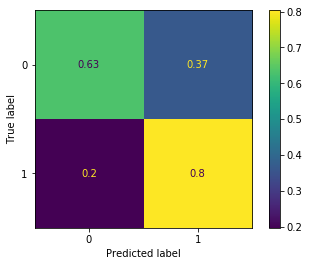

In [75]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Feature Importance

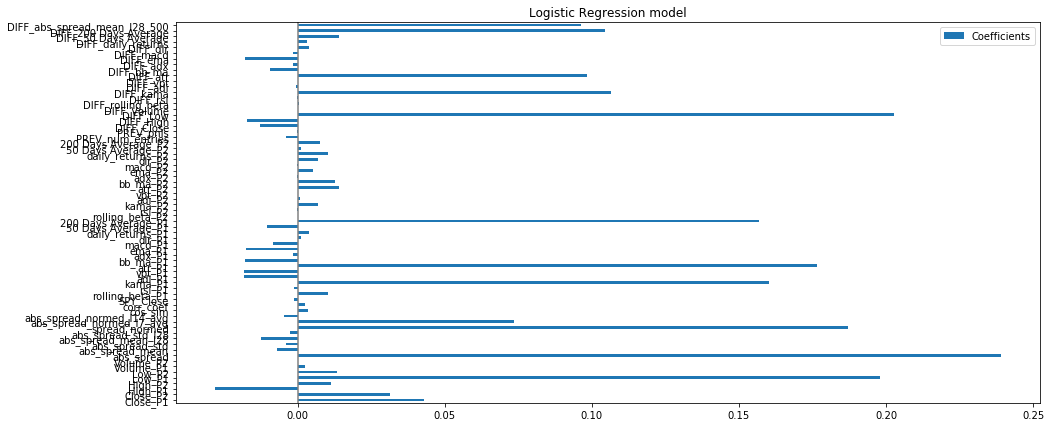

In [76]:
pi = permutation_importance(clf,scaled_X_test,y_test)

coefs = pd.DataFrame(
    #pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
    pi['importances_mean'], columns=["Coefficients"], index=X_train.columns
)

coefs.plot(kind="barh", figsize=(20, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

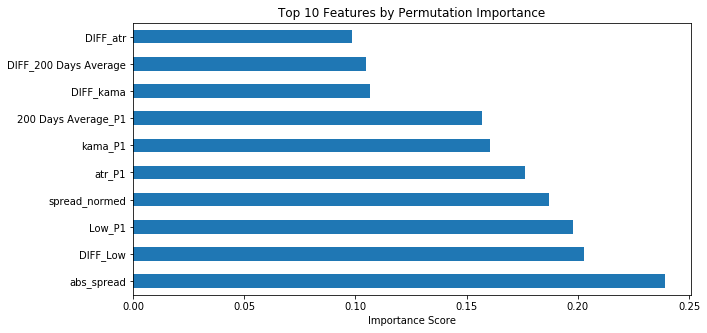

In [77]:
feature_importances = pd.Series(pi['importances_mean'], index=X_train.columns)

# Select the top 10 features
top10_features = feature_importances.abs().nlargest(10).index

# Plot the importance scores for the top 10 features
coefs = feature_importances[top10_features]
coefs.plot(kind="barh", figsize=(10, 5))
plt.title("Top 10 Features by Permutation Importance")
plt.xlabel("Importance Score")
plt.show()

## Logistics Regresssion after feature selection 

In [78]:
X = df[top10_features]
y = df[label]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [80]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-02-05 2019-06-05


In [81]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(663985, 10)
(82998, 10)
(82999, 10)


In [83]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [84]:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

Index([], dtype='object')


In [85]:
#scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)#.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val)#.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test)#.drop(categorical_features,axis=1))

In [86]:
clf = LogisticRegression()

# Train the model using the training sets
clf.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = clf.predict(scaled_X_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [87]:
print(f1_score(y_test, lr_preds, average='weighted'))
print(f1_score(y_test, lr_preds, average='micro'))
print(f1_score(y_test, lr_preds, average='macro'))

0.7881457237109739
0.7761057362136892
0.7416577100579547


In [88]:
cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

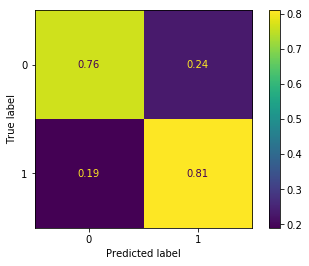

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## GBM

### Optuna

In [ ]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "binary",
#         "metric": "accuracy",
        'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
        "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMClassifier(**params)
    #model.fit(X_train.drop(categorical_features,axis=1),y_train)
    model.fit(X_train,y_train)
    #predictions = model.predict(X_val.drop(categorical_features,axis=1))
    predictions = model.predict(X_val)#.drop(categorical_features,axis=1))
    f1 = f1_score(y_val, predictions, average='weighted')
    return -1*f1

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value*(-1))

In [ ]:
hyper_params = study.best_params

In [84]:
y_train.value_counts()/len(y_train)

0   0.500
1   0.500
Name: PNL_IS_0, dtype: float64

In [ ]:
gbm = lgb.LGBMClassifier(**hyper_params)
callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val)],
        eval_metric='accuracy',
        callbacks=callbacks,
        feature_name = [f for f in features if f not in categorical_features],
#         categorical_feature=categorical_features
       )

In [ ]:
gbm_preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
print(f1_score(y_test, gbm_preds, average='weighted'))
print(f1_score(y_test, gbm_preds, average='micro'))
print(f1_score(y_test, gbm_preds, average='macro'))

In [ ]:
cm = confusion_matrix(y_test, gbm_preds, labels=gbm.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
disp.plot()

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
# STOP

# Regression

## Remove 0s?

In [86]:
df[df.pnls==0].shape[0]*100.0/df.shape[0]

37.425992370918884

In [87]:
df = df[df.pnls!=0]


## X,y split

In [88]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['abs_spread_normed_max','abs_spread_normed_median',\
                    'abs_spread_normed_75th','abs_spread_normed_90th',\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'pnls'



In [90]:
X = df[top10_features]
y = df[label]

In [91]:
# y = pd.Series(np.where(y.abs()<=3.5,0,np.where(y<0,-1,1)))

In [92]:
# y.value_counts()

## Train test split

In [93]:
y.abs().describe(np.arange(0,1,0.1))

count   829982.000
mean         0.374
std          0.484
min          0.000
0%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          1.000
80%          1.000
90%          1.000
max          1.000
Name: PNL_IS_0, dtype: float64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

### Filter Outliers?

In [95]:
u = np.mean(y_train)
s = np.std(y_train)
y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
X_train = X_train.loc[y_train.index]

In [96]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

In [97]:
y_train.value_counts()

0    419255
1    244730
Name: PNL_IS_0, dtype: int64

In [98]:
y_val.value_counts()

1    44850
0    38148
Name: PNL_IS_0, dtype: int64

In [99]:
y_test.value_counts()

0    61950
1    21049
Name: PNL_IS_0, dtype: int64

## GBM

In [99]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "multiclass",
# #         'device':'gpu',
# #         "metric": "accuracy",
# #         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     f1 = f1_score(y_val, predictions, average='weighted')
#     return -1*f1

In [100]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "mse",
#         'device':'gpu',
        "metric": 'l1',
#         'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
#         "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    mae = np.mean(abs(predictions-y_val))
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-06 21:31:06,648] A new study created in memory with name: no-name-029ebc21-1e6e-4d85-a975-03ed6cfdba56


In [ ]:
df[[c for c in features if c not in categorical_features]+[label]].corr()['pnls'].abs().sort_values(ascending=False).head(10)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

In [ ]:
hyper_params = study.best_params

In [ ]:
# hyper_params = {
# #     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'mae',
#     'metric': ['l1'],
# #     'eval_metric': ['l1'],
# #     'early_stopping_rounds':10,
#     'learning_rate': 0.2,
# #     'feature_fraction': 0.9,
# #     'bagging_fraction': 0.7,
# #     'bagging_freq': 10,
#     'verbosity': 1,
# #     "max_depth": 8,
# #     "num_leaves": 128,  
# #     "max_bin": 512,
#     "num_iterations": 200,
#     "importance_type":"gain"
    
# #     "silent":False
# }

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
# gbm = lgb.LGBMClassifier(**hyper_params)

callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val )],
#         eval_metric='l1',
        callbacks=callbacks,
#         feature_name = features,
#         categorical_feature=categorical_features
       )

In [ ]:
# preds = gbm.predict(X_test.drop(categorical_features,axis=1))
# cm = confusion_matrix(y_test, preds, labels=gbm.classes_,normalize='true')
# cm

In [ ]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
# disp.plot()

### GBM feature importance

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
pi = permutation_importance(gbm,X_test.drop(categorical_features,axis=1),y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Error Analysis

In [ ]:
preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
results = pd.DataFrame({'preds':preds,'true':y_test})
results

In [ ]:
results.describe(np.arange(0,1,0.1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [110]:
mean_abs_label = y_test.abs().mean()
mean_abs_label

0.25360546512608584

In [111]:
mae/mean_abs_label

1.2457763747483304

In [112]:
mae_AR1 = (X_test.PREV_pnls - pnl_not_0.true).abs().mean()
mae_AR1

AttributeError: 'DataFrame' object has no attribute 'PREV_pnls'

In [ ]:
mae/mae_AR1

## Linear Regression

In [102]:
scaler = StandardScaler().fit(X_train)#.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train)#.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val)#.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test)#.drop(categorical_features,axis=1))

In [103]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = regr.predict(scaled_X_test)

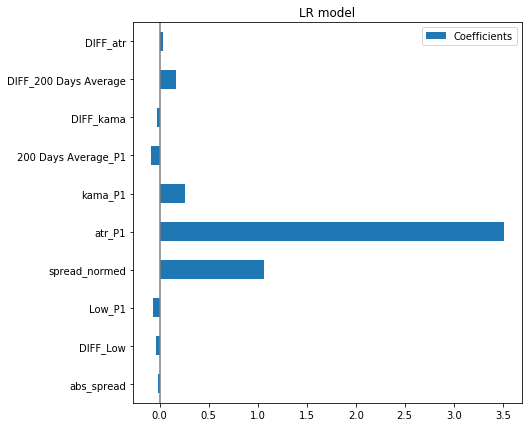

In [105]:
pi = permutation_importance(regr,scaled_X_test,y_test)

coefs = pd.DataFrame(
    #pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
    pi['importances_mean'], columns=["Coefficients"], index=X_train.columns
)


coefs.plot(kind="barh", figsize=(9, 7))
plt.title("LR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [106]:
lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test})
lr_results

,preds,true
1112156,0.677,0
1112157,0.548,0
1112158,0.709,0
1112159,0.580,0
1112160,0.769,1
...,...,...
1195333,0.445,0
1195332,0.502,0
1195331,0.529,0
1195330,0.443,0


In [107]:
lr_pnl_is_0 = lr_results[lr_results.true==0]
lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [108]:
mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()

In [113]:
mae/mean_abs_label

1.2457763747483304

In [114]:
# lr_results.loc[tmp_df.index]

In [115]:
from sklearn.ensemble import RandomForestRegressor

In [116]:
rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [119]:
#rf.fit(X_train.drop(categorical_features,axis=1),y_train)
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.2s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestRegressor(n_jobs=-1, verbose=2)

In [121]:
#preds = rf.predict(X_test.drop(categorical_features,axis=1))
preds = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [122]:
mae = (preds-y_test).abs().mean()
mae

0.22756117543587479

In [123]:
mae/mean_abs_label

0.8973039099245652